In [ ]:
# default_exp features

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
# stellt sicher, dass beim verändern der core library diese wieder neu geladen wird
%load_ext autoreload
%autoreload 2

# Features

Generally, when we create the features (which are mainly ratios or growth rates) we have to ensure that we don't create null/nan or infinite values, since this can cause problem when the data is feed into MachineLearning/RL Algorithms. Moreover, we have to ensure that the datapoint lie in a meaningful range. This mainly means, that we have to handle outliers, which are way out of the normal spectrum.
<br>
Therefore, when we create the features, we will:
- caculate the feature
- handle null/nan values
- ensuring the data lies in a meaningful range
<br>
We mainly use the boxplot visualisation in order to define a meaningful range.

In [ ]:
# imports
from bfh_mt_hs2020_sec_data.core import * 
from pathlib import Path
from typing import List, Tuple, Union, Set

import pandas as pd
import numpy as np

import shutil          # provides high level file operations
import time            # used to measure execution time
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [ ]:
all_combined_folder   = "D:/data_mt/06_combined/"
all_features_folder   = "D:/data_mt/07_features/"
all_data_local_folder = "./data/"

join_group = ["cik","ticker","adsh","period","filed","form","fp"]

## 00_Tools

In [ ]:
def load_combined_data() -> pd.DataFrame:
    df = pd.read_csv(all_combined_folder + "06_all_combined.csv")

    df.period = pd.to_datetime(df.period)
    df.filed = pd.to_datetime(df.filed)
    
    df.sort_values('period', inplace = True)
    df.reset_index(inplace = True)
    df = df.drop(['index'], axis=1)
    return df

In [ ]:
def print_null_counts(df, cols):
    for col in cols:
        null_count = df[col].isnull().sum()
        if null_count > 0:
            print('null: ', col, ' ', null_count)

In [ ]:
def print_inf_counts(df, cols):
    for col in cols:
        inf_count = ((df[col] == np.inf) | (df[col] == -np.inf)).sum()
        if inf_count > 0:
            print('inf: ', col, ' ', inf_count)

In [ ]:
def cap_ratios(df, col, min_value, max_value):
    df.loc[(df[col] ==    np.inf), col] = max_value
    df.loc[(df[col]  > max_value), col] = max_value
    df.loc[(df[col] ==   -np.inf), col] = min_value
    df.loc[(df[col]  < min_value), col] = min_value

## 01_Load

In [ ]:
df = load_combined_data()
print(df.shape)
print((set(df.columns) - set(join_group)))

(95395, 28)
{'AssetsNoncurrent', 'c_Revenues', 'bs_qtrs', 'c_PaymentsOfDividendsTotal', 'Liabilities', 'is_qtrs', 'c_CashIncreaseDecrease', 'c_Equity', 'c_RetainedEarnings', 'cf_qtrs', 'LiabilitiesCurrent', 'LiabilitiesNoncurrent', 'c_PaymentsForRepurchaseOfStockTotal', 'c_NetIncomeLoss', 'c_OperatingIncomeLoss', 'GrossProfit', 'c_CashFromInvesting', 'AssetsCurrent', 'c_CashFromOperating', 'Assets', 'c_CashFromFinancing'}


## 02_Basic Features

In [ ]:
df['period_day_of_week']   = df.period.dt.dayofweek
df['period_day_of_month']  = df.period.dt.day
df['period_day_of_year']   = df.period.dt.dayofyear
df['period_week_of_year']  = df.period.dt.weekofyear
df['period_month_of_year'] = df.period.dt.month

## 03_In-report Ratios Features

Contains features, that are created based on the data inside a single report.

**BalanceSheet Ratios**
- WorkingCapitalToAssets = (CurrentAssets - CurrentLiabilities) / CurrentAssets
- CurrentRatio = CurrentAssets / CurrentLiabilities
- DebtToEquity = Liabilities / Equity
- DebtRatio = TotalLiabilities/TotalAssets


**IncomeStatement Ratios**
- NetProfitMargin  = GrossProfit / Revenues
- OperatingMargin  = OperatingIncome / Revenues
- NetIncomeMargin  = NetIncome / Revenues 


**Cashflow Ratios**
- CashGeneratingPowerRatio = CashFromOperations / (CashFromOperations + CashFromFinancing + CashFromInvesting)
- ExternalFinancingIndexRatio = CashFromFinancing / CashFromOperations)


**IncomeStatment / BalanceSheet**
- ReturnOnEquity = NetIncome / (Average) Equity 
- ReturnOnAssets = NetIncome / TotalAssets
- AssetsTurnoverRatio = NetSales / TotalAssets

(Variation: NetIncome: use TTM NetIncome -> NetIncome during the last 12 months)
(Variation: Total Assets: Use average of Assets over the period)


**IncomeStatement / CashFlow**
- DividendPayoutRatio = DividendsPaid / NetIncome
- StockRepurchaseRatio = PaymentsForStockRepurchase / NetIncome 
- OperatingCashFlowRatio = CashFromOperations / Revenue


**BalanceSheet / CashFlow**
- AssetEfficiencyRatio = CashFromOperations / Assets
- CurrentLiabilityCoverageRatio = (CashFromOperations - DividendsPaid)/CurrentLiabilities
- LongTermDebtCoverageRatio = (CashFromOperations - DividendsPaid)/NonCurrentLiabilities

### BalanceSheet Ratios
#### calculate

In [ ]:
bs_ratio_cols = ['r_workcapToAssets','r_currentRatio','r_deptToEquity','r_deptRatio']

In [ ]:
# WorkingCapitalToAssets = (CurrentAssets - CurrentLiabilities) / CurrentAssets
df['r_workcapToAssets'] = (df.AssetsCurrent - df.LiabilitiesCurrent) / df.AssetsCurrent

# CurrentRatio = CurrentAssets / CurrentLiabilities
df['r_currentRatio']  = df.AssetsCurrent / df.LiabilitiesCurrent

# DebtToEquity = Liabilities / Equity
df['r_deptToEquity']  = df.Liabilities / df.c_Equity

# DebtRatio = TotalLiabilities/TotalAssets
df['r_deptRatio']  = df.Liabilities / df.Assets

In [ ]:
# check for null/nan and inf values
print_inf_counts(df, bs_ratio_cols)
print_null_counts(df, bs_ratio_cols)

inf:  r_currentRatio   2
inf:  r_deptToEquity   5
null:  r_workcapToAssets   4
null:  r_currentRatio   4
null:  r_deptToEquity   4
null:  r_deptRatio   4


#### correct null/na

In [ ]:
# WorkingCapitalToAssets = (CurrentAssets - CurrentLiabilities) / CurrentAssets
df.loc[df.r_workcapToAssets.isnull() & (df.LiabilitiesCurrent == 0.0), 'r_workcapToAssets'] = 1.0

# CurrentRatio = CurrentAssets / CurrentLiabilities
# if there is no current dept, set the current ratio to 1
df.loc[df.r_currentRatio.isnull() & (df.LiabilitiesCurrent == 0.0), 'r_currentRatio'] = 1.0

# DebtToEquity = Liabilities / Equity
df.loc[df.r_deptToEquity.isnull() & (df.Liabilities == 0.0), 'r_deptToEquity'] = 0.0

# DebtRatio = TotalLiabilities/TotalAssets
# if there is no total dept, set the deptRatio to 1
df.loc[df.r_deptRatio.isnull() & (df.Liabilities == 0.0), 'r_deptRatio'] = 1.0

#### correct range

In [ ]:
cap_ratios(df, 'r_deptToEquity', -5, 7) # a good ratio is below 2
cap_ratios(df, 'r_currentRatio', 0, 7) # a good current ratio is between 1..2, a 10
cap_ratios(df, 'r_deptRatio',   0, 3) #  a good debt to asset ratio should be below 1, so a 5 is already a bad sign
cap_ratios(df, 'r_workcapToAssets',   -2, 5) #  a good debt to asset ratio should be below 1, so a 5 is already a bad sign

<AxesSubplot:>

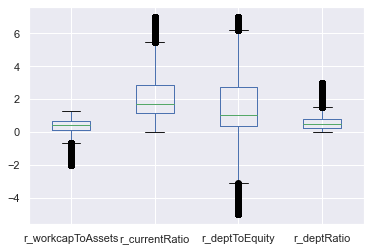

In [ ]:
df[bs_ratio_cols].plot.box()

In [ ]:
# final check for null/nan and inf values
print_inf_counts(df, bs_ratio_cols)
print_null_counts(df, bs_ratio_cols)

### IncomeStatement Ratios
#### calculate

In [ ]:
is_ratio_cols = ['r_netProfitMargin','r_operatingMargin','r_netIncomeMargin']

In [ ]:
# NetProfitMargin  = GrossProfit / Revenues
df['r_netProfitMargin'] = df.GrossProfit / df.c_Revenues

# OperatingMargin  = OperatingIncome / Revenues
df['r_operatingMargin'] = df.c_OperatingIncomeLoss / df.c_Revenues

# NetIncomeMargin  = NetIncome / Revenues 
df['r_netIncomeMargin'] = df.c_NetIncomeLoss / df.c_Revenues

In [ ]:
# check for null/nan and inf values
print_inf_counts(df, is_ratio_cols)
print_null_counts(df, is_ratio_cols)

inf:  r_netProfitMargin   2239
inf:  r_operatingMargin   3526
inf:  r_netIncomeMargin   3526
null:  r_netProfitMargin   1287


#### correct null/na

In [ ]:
# if there is no GrossProfit, set, netProfitMargin to 0.0
df.loc[df.r_netProfitMargin.isnull() & (df.GrossProfit == 0.0), 'r_netProfitMargin'] = 0.0

#### correct range

In [ ]:
# this ratios should be between 0 and 1, everything else is not "normal". Therefore, we limit the range to -1..2
cap_ratios(df, 'r_netProfitMargin', -1, 2)
cap_ratios(df, 'r_operatingMargin', -1, 1)
cap_ratios(df, 'r_netIncomeMargin', -1, 1)

<AxesSubplot:>

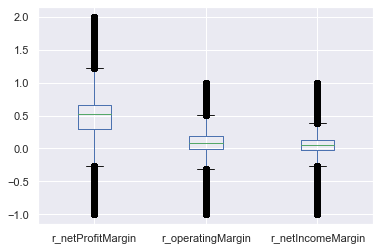

In [ ]:
df[is_ratio_cols].plot.box()

In [ ]:
# final check for null/nan and inf values
print_inf_counts(df, is_ratio_cols)
print_null_counts(df, is_ratio_cols)

### CashFlow Ratios
#### calculate

In [ ]:
cf_ratio_cols = ['r_cashGenPowerRatio','r_extFinancingIndexRatio']

In [ ]:
# CashGeneratingPowerRatio = CashFromOperations / (CashFromOperations + CashFromFinancing + CashFromInvesting)
df['r_cashGenPowerRatio'] = df.c_c_CashFromOperating / (df.c_c_CashFromOperating + df.c_CashFromFinancing + df.c_CashFromInvesting)

# ExternalFinancingIndexRatio = CashFromFinancing / CashFromOperations)
df['r_extFinancingIndexRatio'] = df.c_CashFromFinancing / df.c_c_CashFromOperating

In [ ]:
# check for null/nan and inf values
print_inf_counts(df, cf_ratio_cols)
print_null_counts(df, cf_ratio_cols)

inf:  r_cashGenPowerRatio   262
inf:  r_extFinancingIndexRatio   3
null:  r_cashGenPowerRatio   4
null:  r_extFinancingIndexRatio   4


#### correct null/na

In [ ]:
df.loc[df.r_cashGenPowerRatio.isnull() & (df.c_c_CashFromOperating == 0.0), 'r_cashGenPowerRatio'] = 0.0
df.loc[df.r_extFinancingIndexRatio.isnull() & (df.c_CashFromFinancing == 0.0), 'r_extFinancingIndexRatio'] = 0.0

#### correct range

In [ ]:
cap_ratios(df, 'r_cashGenPowerRatio', -5, 10)
cap_ratios(df, 'r_extFinancingIndexRatio', -5, 5)

<AxesSubplot:>

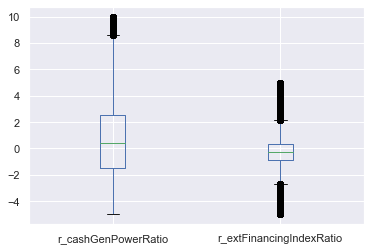

In [ ]:
df[cf_ratio_cols].plot.box()

In [ ]:
# final check for null/nan and inf values
print_inf_counts(df, cf_ratio_cols)
print_null_counts(df, cf_ratio_cols)

### IncomeStatment / BalanceSheet Ratios
#### calculate

In [ ]:
isbs_ratio_cols = ['r_returnOnEquity','r_returnOnAssets','r_assetsTurnoverRatio']

In [ ]:
# ReturnOnEquity = NetIncome / (Average) Equity 
df['r_returnOnEquity'] = df.c_NetIncomeLoss / df.c_Equity

# ReturnOnAssets = NetIncome / TotalAssets
df['r_returnOnAssets'] = df.c_NetIncomeLoss / df.Assets

# AssetsTurnoverRatio = NetSales / TotalAssets
df['r_assetsTurnoverRatio'] = df.c_Revenues / df.Assets 

In [ ]:
# check for null/nan and inf values
print_inf_counts(df, isbs_ratio_cols)
print_null_counts(df, isbs_ratio_cols)

inf:  r_returnOnEquity   9
inf:  r_returnOnAssets   4
inf:  r_assetsTurnoverRatio   4


#### correct range

In [ ]:
cap_ratios(df, 'r_returnOnEquity',     -0.5, 0.5)
cap_ratios(df, 'r_returnOnAssets',     -0.25, 0.25)
cap_ratios(df, 'r_assetsTurnoverRatio',-1, 1)

<AxesSubplot:>

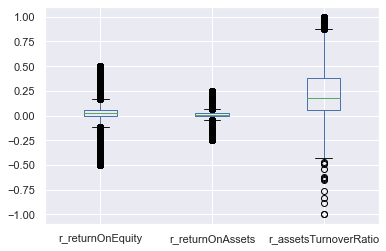

In [ ]:
df[isbs_ratio_cols].plot.box()

In [ ]:
# final check for null/nan and inf values
print_inf_counts(df, isbs_ratio_cols)
print_null_counts(df, isbs_ratio_cols)

### IncomeStatement / CashFlow
#### calculate

In [ ]:
iscf_ratio_cols = ['r_dividendPayoutRatio','r_stockRepurchaseRatio','r_operatingCashFlowRatio']

In [ ]:
# Dividend Payout Ratio = DividendsPaid / NetIncome
df['r_dividendPayoutRatio'] = df.c_PaymentsOfDividendsTotal / df.c_NetIncomeLoss

# StockRepurchaseRatio = PaymentsForStockRepurchase / NetIncome 
df['r_stockRepurchaseRatio'] = df.c_PaymentsForRepurchaseOfStockTotal / df.c_NetIncomeLoss

# Operating Cash Flow Ratio = CashFromOperations / Revenue
df['r_operatingCashFlowRatio'] = df.c_c_CashFromOperating / df.c_Revenues

In [ ]:
# check for null/nan and inf values
print_inf_counts(df, iscf_ratio_cols)
print_null_counts(df, iscf_ratio_cols)

inf:  r_dividendPayoutRatio   2
inf:  r_stockRepurchaseRatio   3
inf:  r_operatingCashFlowRatio   3526
null:  r_dividendPayoutRatio   3
null:  r_stockRepurchaseRatio   2


#### correct null/na

In [ ]:
# df['r_dividendPayoutRatio'] = df.c_PaymentsOfDividendsTotal / df.c_NetIncomeLoss
df.loc[df.r_dividendPayoutRatio.isnull() & (df.c_PaymentsOfDividendsTotal == 0.0), 'r_dividendPayoutRatio'] = 0.0

# df['r_stockRepurchaseRatio'] = df.c_PaymentsForRepurchaseOfStockTotal / df.c_NetIncomeLoss
df.loc[df.r_stockRepurchaseRatio.isnull() & (df.c_PaymentsForRepurchaseOfStockTotal == 0.0), 'r_stockRepurchaseRatio'] = 0.0

#### correct range

In [ ]:
cap_ratios(df, 'r_dividendPayoutRatio', -2, 2)
cap_ratios(df, 'r_stockRepurchaseRatio', -2, 2)
cap_ratios(df, 'r_operatingCashFlowRatio', -2, 2)

<AxesSubplot:>

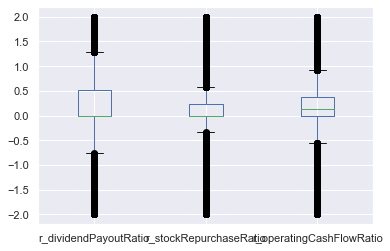

In [ ]:
df[iscf_ratio_cols].plot.box()

In [ ]:
# final check for null/nan and inf values
print_inf_counts(df, iscf_ratio_cols)
print_null_counts(df, iscf_ratio_cols)

### BalanceSheet / CashFlow
#### calculate

In [ ]:
bscf_ratio_cols = ['r_assetEfficiencyRatio','r_currentLiabCoverageRatio','r_longtermDeptCoverageRatio']

In [ ]:
# AssetEfficiencyRatio = CashFromOperations / Assets
df['r_assetEfficiencyRatio'] = df.c_CashFromOperating / df.Assets 

# CurrentLiabilityCoverageRatio = (CashFromOperations - DividendsPaid) / CurrentLiabilities
df['r_currentLiabCoverageRatio'] = (df.c_CashFromOperating - df.c_PaymentsOfDividendsTotal) / df.LiabilitiesCurrent  

# LongTermDebtCoverageRatio = (CashFromOperations - DividendsPaid) / NonCurrentLiabilities
df['r_longtermDeptCoverageRatio']  =  (df.c_CashFromOperating - df.c_PaymentsOfDividendsTotal) / df.LiabilitiesNoncurrent

In [ ]:
# check for null/nan and inf values
print_inf_counts(df, bscf_ratio_cols)
print_null_counts(df, bscf_ratio_cols)

inf:  r_assetEfficiencyRatio   4
inf:  r_currentLiabCoverageRatio   6
inf:  r_longtermDeptCoverageRatio   39262
null:  r_longtermDeptCoverageRatio   23


#### correct null/na

In [ ]:
df.loc[(df.r_longtermDeptCoverageRatio.isnull() &(df.LiabilitiesNoncurrent == 0.0)), 'r_longtermDeptCoverageRatio'] = 10.0

#### correct range

In [ ]:
cap_ratios(df, 'r_longtermDeptCoverageRatio', -10, 10)
cap_ratios(df, 'r_currentLiabCoverageRatio', -1, 1)
cap_ratios(df, 'r_assetEfficiencyRatio', -0.5, 0.5)

<AxesSubplot:>

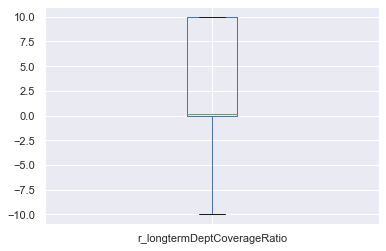

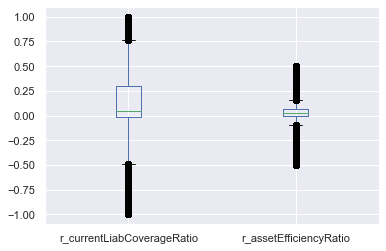

In [ ]:
df.r_longtermDeptCoverageRatio.plot.box()
df[['r_currentLiabCoverageRatio','r_assetEfficiencyRatio']].plot.box()

In [ ]:
# final check for null/nan and inf values
print_inf_counts(df, bscf_ratio_cols)
print_null_counts(df, bscf_ratio_cols)

### Save

In [ ]:
df.to_csv(all_features_folder + "07_01_features_ratios.csv", index=False)

# make copy to directory under git control
shutil.copy(all_features_folder + "07_01_features_ratios.csv", all_data_local_folder + "07_01_features_ratios.csv")

'./data/07_01_features_ratios.csv'

## 04_Increase/Decrease Features - "Change Ratios"

The growthrate of an attribute is defined by <br>
(newValue - lastValue) / lastValue

For instance: lastYearsRevenue = 10 Mio, thisYearRevenue = 20 Mio => (20 - 10) / 10 = 2

But we have distinguish if "lastValue" was negativ.<p>
For instance: lastYearsRevenue = -10 Mio, thisYearRevenue = -20 Mio => (-20 - -10) / -10 => (-20 + 10) / -10 = 2<br>
Would also equals to 2.0, as in the example with 20Mio and 10Mio
<p>
Therefore, for every "growthrate"-feature two features will be created. The first one ends with "_p" and contains the value when the "lastValue" was > 0 and the second names with "_n" and contains the results when "lastValue" was < 0.

This is done based on the Quater, so Q1 data are compared with the last Q1, Q2 with the last Q2, Q3 with the last Q3 and FY with the last FY. 

Growth-Rates for the following positions will be calculated:
<br>
**BalanceSheet GrowthRatios for**
- AssetsCurrent
- AssetsNoncurrent
- LiabilitiesCurrent
- LiabilitiesNoncurrent
- c_Equity
- c_RetainedEarnings
    
**IncomeStatement GrowthRatios for**  
- c_Revenues
- GrossProfit
- c_OperatingIncomeLoss
- c_NetIncomeLoss

**CashflowStatement GrowthRatios for**
- c_CashFromInvesting
- c_CashFromFinancing
- c_CashFromOperating
- c_PaymentsOfDividendsTotal



In [ ]:
def calculate_growth(all_df: pd.DataFrame, grouped_df: pd.DataFrame, data_cols:List[str], new_cols_prefix:List[str]):
    
    for data_col, new_col_prefix in zip(data_cols, new_cols_prefix):
        col_name_p = new_col_prefix + "_p"
        col_name_n = new_col_prefix + "_n"
        
        all_df.loc[grouped_df.index[0], col_name_p] = 0.0
        all_df.loc[grouped_df.index[0], col_name_n] = 0.0
    
        is_positiv_arr = (grouped_df[data_col] > 0.0).to_numpy()
        is_negativ_arr = (grouped_df[data_col] < 0.0).to_numpy()
        data_arr = all_df.loc[grouped_df.index, data_col].to_numpy()
        
        change_arr = ((data_arr[1:] - data_arr[:-1]) / data_arr[:-1])

        all_df.loc[grouped_df.index[1:], col_name_p] =  is_positiv_arr[:-1] * change_arr
        all_df.loc[grouped_df.index[1:], col_name_n] =  is_negativ_arr[:-1] * change_arr

In [ ]:
list_data_cols = ['c_Revenues', 'GrossProfit', 'c_OperatingIncomeLoss', 'c_NetIncomeLoss', 'c_RetainedEarnings', 'c_Equity']
list_new_cols  = ['gr_revenue', 'gr_grosspr' , 'gr_opiincome',          'gr_netincome',    'gr_earnings',        'gr_equity']

list_data_cols.extend(['AssetsCurrent', 'AssetsNoncurrent', 'LiabilitiesCurrent', 'LiabilitiesNoncurrent'])
list_new_cols.extend( ['gr_asscur',     'gr_assnoncur',     'gr_liabcur',         'gr_liabnoncur'        ])

list_data_cols.extend(['c_CashFromInvesting', 'c_CashFromFinancing', 'c_CashFromOperating', 'c_PaymentsOfDividendsTotal'])
list_new_cols.extend( ['gr_cashfrominv',      'gr_cashfromfin',      'gr_cashfromope',      'gr_dividends'])

In [ ]:
# multiprocessing is not really working in jupyter on windows
# therfore there ist the 07_features_growth.py skript, which which enables multiprocessing

start = time.time()
for ticker, entry in df.groupby(['cik', 'fp']):
    print('.',end="")
    calculate_growth(df, entry, list_data_cols, list_new_cols)
print("duration: ", time.time() - start)

### Save raw

In [ ]:
df.to_csv(all_features_folder + "07_02_features_growth_raw.csv", index=False)

# make copy to directory under git control
shutil.copy(all_features_folder + "07_02_features_growth_raw.csv", all_data_local_folder + "07_02_features_growth_raw.csv")

## 05_Correct_ChangeRatios

In [ ]:
df = pd.read_csv(all_features_folder + "07_02_features_growth.csv", header = 0)
df = df.drop(['index'], axis=1)
gr_cols = [ x for x in df.columns.to_list() if "gr_" in x ]

In [ ]:
print_inf_counts(df, gr_cols)
print_null_counts(df, gr_cols)

null:  gr_revenue_n   3101
null:  gr_revenue_p   3101
null:  gr_grosspr_n   1113
null:  gr_grosspr_p   1113
null:  gr_opiincome_n   4
null:  gr_opiincome_p   4
null:  gr_netincome_n   5
null:  gr_netincome_p   5
null:  gr_earnings_n   5756
null:  gr_earnings_p   5756
null:  gr_equity_n   5
null:  gr_equity_p   5
null:  gr_assnoncur_n   19000
null:  gr_assnoncur_p   19000
null:  gr_liabcur_n   2
null:  gr_liabcur_p   2
null:  gr_liabnoncur_n   34550
null:  gr_liabnoncur_p   34550
null:  gr_cashfrominv_n   1123
null:  gr_cashfrominv_p   1123
null:  gr_cashfromfin_n   1447
null:  gr_cashfromfin_p   1447
null:  gr_cashfromope_n   3
null:  gr_cashfromope_p   3
null:  gr_dividends_n   40551
null:  gr_dividends_p   40551


In [ ]:
def correct_null_gr(df: pd.DataFrame, base_col: str, gr_col_prefix: str):
    df.loc[(df[gr_col_prefix + '_p'].isnull() & (df[base_col] == 0.0)), gr_col_prefix + '_p']  =  0.0 
    df.loc[(df[gr_col_prefix + '_n'].isnull() & (df[base_col] == 0.0)), gr_col_prefix + '_n']  =  0.0 
    df.loc[(df[gr_col_prefix + '_p'].isnull() & (df[base_col]  > 0.0)), gr_col_prefix + '_p']  =  1.0 
    df.loc[(df[gr_col_prefix + '_n'].isnull() & (df[base_col]  > 0.0)), gr_col_prefix + '_n']  =  0.0 
    df.loc[(df[gr_col_prefix + '_p'].isnull() & (df[base_col]  < 0.0)), gr_col_prefix + '_p']  =  0.0     
    df.loc[(df[gr_col_prefix + '_n'].isnull() & (df[base_col]  < 0.0)), gr_col_prefix + '_n']  = -1.0 

### BalanceSheet GrowthRatios

In [ ]:
bs_gr_cols = ['gr_asscur_n', 'gr_assnoncur_n', 'gr_liabcur_n', 'gr_liabnoncur_n', 'gr_earnings_n', 'gr_equity_n',
              'gr_asscur_p', 'gr_assnoncur_p', 'gr_liabcur-p', 'gr_liabnoncur_p', 'gr_earnings_p', 'gr_equity_p' ]

#### correct null/na

In [ ]:
df.gr_assnoncur_n  = 0.0 # no "negative" assets  are possible
df.gr_asscur_n     = 0.0 # no "negative" assets  are possible
df.gr_liabcur_n    = 0.0 # no "negative" values for liabilities  are possible
df.gr_liabnoncur_n = 0.0 # no "negative" values liabilities  are possible


correct_null_gr(df, 'AssetsCurrent',         'gr_asscur')
correct_null_gr(df, 'AssetsNoncurrent',      'gr_assnoncur')
correct_null_gr(df, 'LiabilitiesCurrent',    'gr_liabcur')
correct_null_gr(df, 'LiabilitiesNoncurrent', 'gr_liabnoncur')
correct_null_gr(df, 'c_RetainedEarnings',    'gr_earnings')
correct_null_gr(df, 'c_Equity',              'gr_equity')

#### correct range

In [ ]:
cap_ratios(df, 'gr_asscur_p',     -0.75, 0.75)
cap_ratios(df, 'gr_assnoncur_p',  -0.5, 0.5)
cap_ratios(df, 'gr_liabcur_p',    -1, 1)
cap_ratios(df, 'gr_liabnoncur_p', -0.5, 0.5)
cap_ratios(df, 'gr_earnings_p',   -0.5, 0.5)
cap_ratios(df, 'gr_earnings_n',   -0.5, 0.5)
cap_ratios(df, 'gr_equity_p',     -0.5, 0.5)
cap_ratios(df, 'gr_equity_n',     -0.2, 0.2)

### Income Statement GrowthRatios

In [ ]:
is_gr_cols = ['gr_revenue_n', 'gr_grosspr_n', 'gr_opiincome_n', 'gr_netincome_n',
              'gr_revenue_p', 'gr_grosspr_p', 'gr_opiincome_p', 'gr_netincome_p' ]

#### correct null/na

In [ ]:
correct_null_gr(df, 'c_Revenues',            'gr_revenue')
correct_null_gr(df, 'GrossProfit',           'gr_grosspr')
correct_null_gr(df, 'c_OperatingIncomeLoss', 'gr_opiincome')
correct_null_gr(df, 'c_NetIncomeLoss',       'gr_netincome')

#### correct range

In [ ]:
cap_ratios(df, 'gr_revenue_p',   -0.75, 0.75)
cap_ratios(df, 'gr_revenue_n',   -0.75, 0.75)
cap_ratios(df, 'gr_grosspr_n',   -0.5, 0.5)
cap_ratios(df, 'gr_grosspr_p',   -0.75, 0.75)
cap_ratios(df, 'gr_opiincome_n', -0.5, 0.5)
cap_ratios(df, 'gr_opiincome_p', -0.75, 0.75)
cap_ratios(df, 'gr_netincome_n', -0.5, 0.5)
cap_ratios(df, 'gr_netincome_p', -0.75, 0.75)

### CashflowStatement GrowthRatios

In [ ]:
cf_gr_cols = ['gr_cashfrominv_p','gr_cashfromfin_p','gr_cashfromope_p','gr_dividends_p',
              'gr_cashfrominv_n','gr_cashfromfin_n','gr_cashfromope_n','gr_dividends_n']

#### correct null/na

In [ ]:
df.gr_dividends_n = 0.0 # no "negativ" previous value are possible
df.loc[(df.gr_dividends_p.isnull() &(df.c_PaymentsOfDividendsTotal == 0.0)), 'gr_dividends_p'] = 0.0

# we give some credit that a dividend was payed compared to the prior period. 
# however the real value would be infinite which doesn' make sense, so we reduce that to 100%

df.loc[(df.gr_dividends_p.isnull() &(df.c_PaymentsOfDividendsTotal > 0.0)), 'gr_dividends_p']  = 1.0 

In [ ]:
correct_null_gr(df, 'c_CashFromInvesting', 'gr_cashfrominv')
correct_null_gr(df, 'c_CashFromFinancing', 'gr_cashfromfin')
correct_null_gr(df, 'c_CashFromOperating', 'gr_cashfromope')

#### correct range

In [ ]:
cap_ratios(df, 'gr_dividends_p',    0, 1)
cap_ratios(df, 'gr_cashfrominv_n', -3, 3)
cap_ratios(df, 'gr_cashfrominv_p', -1, 1)
cap_ratios(df, 'gr_cashfromfin_n', -1, 1)
cap_ratios(df, 'gr_cashfromfin_p', -0.1,  0.1)
cap_ratios(df, 'gr_cashfromope_n', -0.05, 0.05)
cap_ratios(df, 'gr_cashfromope_p', -0.5,  0.5)

In [ ]:
print_inf_counts(df, gr_cols)
print_null_counts(df, gr_cols)

## save

In [ ]:
df.to_csv(all_features_folder + "07_03_features_growth.csv", index=False)

# make copy to directory under git control
shutil.copy(all_features_folder + "07_03_features_growth.csv", all_data_local_folder + "07_03_features_growth.csv")

## 06_Financial Period one-hot-encoding

### add one hot_encoding for financial period

In [ ]:
df = pd.read_csv(all_features_folder + "07_03_features_growth.csv", header = 0)

In [ ]:
df = pd.concat([df, pd.get_dummies(df.fp, prefix='fp_')], axis=1)
df.shape

(95395, 84)

### save

In [ ]:
df.to_csv(all_features_folder + "07_04_features_fp.csv", header=True, index=False)

# make copy to directory under git control
shutil.copy(all_features_folder + "07_04_features_fp.csv", all_data_local_folder + "07_04_features_fp.csv")

'./data/07_04_features_fp.csv'

## XX_Trials

<AxesSubplot:>

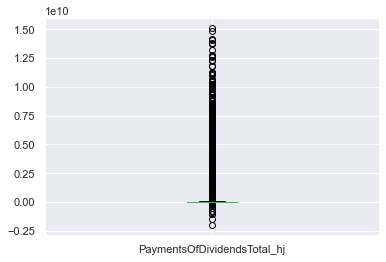

In [ ]:
df_raw.c_PaymentsOfDividendsTotal.plot.box()

In [ ]:
#df[df.ticker == 'AAPL'].sort_values('period')[['adsh','period', 'period_year','fp','bs_qtrs','is_qtrs','cf_qtrs','c_CashFromOperating','CashFromFinancing','CashFromInvesting','c_RetainedEarnings']]
df[df.ticker == 'AAPL'].sort_values('period')[['period', 'period_year','fp','c_Revenues','c_CashFromOperating','CashFromFinancing','CashFromInvesting','c_RetainedEarnings']]

In [ ]:
df[df.ticker == 'AAPL'].sort_values('period')[['c_Revenues', 'period']].set_index('period').plot()

In [ ]:
test_df = df[df.ticker.isin(['AAPL','INTC'])].sort_values('period').copy().reset_index()
test_df[:15]

In [ ]:
df_sample = pd.DataFrame({'A' :  ['AAPL',  'AAPL', 'AAPL', 'AAPL', 'INTC',  'INTC',   'INTC'],
                          'B' :  ['Q1',    'Q2',   'Q3',    'Q4',  'Q1',    'Q2',     'Q3'],
                          'C' :  [ 1.0,    -1.0,    -2.0,   2.0,   1.0,      2.0,       3.0] \
                  })

In [ ]:

for ticker, entry in df_sample.groupby(['A']):
    print(ticker, " ", entry.shape)

    df_sample.loc[entry.index[0], 'D1'] = 1.0
    df_sample.loc[entry.index[0], 'D2'] = 0.0
        
    pos_arr = (entry['C'] > 0.0).to_numpy()
    arr = df_sample.loc[entry.index, 'C'].to_numpy()
    
    df_sample.loc[entry.index[1:], 'D1'] = pos_arr[:-1] * ((arr[1:] - arr[:-1]) / arr[:-1])
    df_sample.loc[entry.index[1:], 'D2'] = (pos_arr[:-1] == False) * ((arr[1:] - arr[:-1]) / arr[:-1])
        
    print("", end = "\n\n")
    
df_sample.sort_values('A')

In [ ]:
def func(x):
    print(type(x))
    if type(x) == pd.DataFrame:
        print("yes: ", x.columns)
        x.C = x.C[1:] / x.C[:-1]
        x.C[0] = 1.0
        
    print('-------')
    return x

In [ ]:
df_sample.groupby(['A']).transform(func)

In [ ]:
c = df_sample.C
c

In [ ]:
c[1:].array / c[:-1].array

In [ ]:
np_arr = c.array
print(np_arr)
np_arr[1:] = np_arr[1:] / np_arr[:-1]
np_arr[0] = 1.0
print(np_arr)

In [ ]:
c

In [ ]:
mylist(df.groupby(['cik', 'fp']))[]

<AxesSubplot:xlabel='period'>

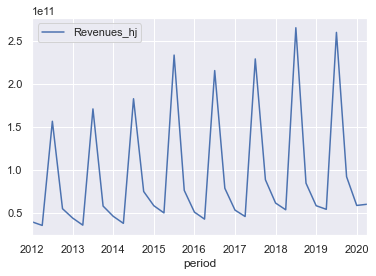

In [ ]:
test_df = df[df.ticker.isin(['AAPL','INTC'])].sort_values('period').copy().reset_index()
test_df[:15]

,index,cik,ticker,adsh,period,filed,form,bs_qtrs,fp,Assets,...,r_returnOnAssets,r_assetsTurnoverRatio,r_dividendPayoutRatio,r_stockRepurchaseRatio,r_operatingCashFlowRatio,r_assetEfficiencyRatio,r_currentLiabCoverageRatio,r_longtermDeptCoverageRatio,period_year,period_month
0,91201,320193,AAPL,0001193125-12-182321,2012-03-31,2012-04-25,10-Q,0.0,Q2,1.509340e+11,...,0.077001,0.259623,0.000000,0.000000,0.804650,0.208906,0.984236,1.922622,2012,2012-03
1,6675,50863,INTC,0001193125-12-212253,2012-03-31,2012-05-04,10-Q,0.0,Q1,7.181700e+10,...,0.038125,0.179707,0.383126,0.554785,0.230280,0.041383,0.161042,inf,2012,2012-03
2,32844,50863,INTC,0001193125-12-329132,2012-06-30,2012-08-01,10-Q,0.0,Q2,7.235200e+10,...,0.039073,0.186602,0.744959,1.031128,0.571143,0.106576,0.531885,inf,2012,2012-06
3,17177,320193,AAPL,0001193125-12-314552,2012-06-30,2012-07-25,10-Q,0.0,Q3,1.628960e+11,...,0.054170,0.215002,0.000000,0.000000,1.191217,0.256114,1.261948,2.306247,2012,2012-06
4,87974,320193,AAPL,0001193125-12-444068,2012-09-30,2012-10-31,10-K,0.0,FY,1.760640e+11,...,0.237033,0.888927,0.000000,0.000000,0.324942,0.288850,1.319496,2.633389,2012,2012-09
5,14308,50863,INTC,0001193125-12-444095,2012-09-30,2012-10-31,10-Q,0.0,Q3,7.444100e+10,...,0.039924,0.180774,1.087147,1.376178,0.955488,0.172727,0.805405,inf,2012,2012-09
6,83302,320193,AAPL,0001193125-13-022339,2012-12-31,2013-01-24,10-Q,0.0,Q1,1.960880e+11,...,0.066695,0.277998,0.000000,0.149105,0.429740,0.119467,0.499712,1.071491,2012,2012-12
7,20567,50863,INTC,0001193125-13-065416,2012-12-31,2013-02-19,10-K,0.0,FY,8.435100e+10,...,0.130467,0.632370,0.395275,0.464334,0.354024,0.223874,1.126841,inf,2012,2012-12
8,58808,50863,INTC,0000050863-13-000043,2013-03-31,2013-04-29,10-Q,0.0,Q1,8.308300e+10,...,0.024614,0.151415,0.544743,0.273350,0.340620,0.051575,0.268774,inf,2013,2013-03
9,81220,320193,AAPL,0001193125-13-168288,2013-03-31,2013-04-24,10-Q,0.0,Q2,1.947430e+11,...,0.049024,0.223900,0.000000,0.204253,0.824026,0.184500,1.011885,1.513161,2013,2013-03


In [ ]:
df_sample = pd.DataFrame({'A' :  ['AAPL',  'AAPL', 'AAPL', 'AAPL', 'INTC',  'INTC',   'INTC'],
                          'B' :  ['Q1',    'Q2',   'Q3',    'Q4',  'Q1',    'Q2',     'Q3'],
                          'C' :  [ 1.0,    -1.0,    -2.0,   2.0,   1.0,      2.0,       3.0] \
                  })

In [ ]:

for ticker, entry in df_sample.groupby(['A']):
    print(ticker, " ", entry.shape)

    df_sample.loc[entry.index[0], 'D1'] = 1.0
    df_sample.loc[entry.index[0], 'D2'] = 0.0
        
    pos_arr = (entry['C'] > 0.0).to_numpy()
    arr = df_sample.loc[entry.index, 'C'].to_numpy()
    
    df_sample.loc[entry.index[1:], 'D1'] = pos_arr[:-1] * ((arr[1:] - arr[:-1]) / arr[:-1])
    df_sample.loc[entry.index[1:], 'D2'] = (pos_arr[:-1] == False) * ((arr[1:] - arr[:-1]) / arr[:-1])
        
    print("", end = "\n\n")
    
df_sample.sort_values('A')

AAPL   (4, 3)
[ True False False  True]


INTC   (3, 3)
[ True  True  True]




,A,B,C,D1,D2
0,AAPL,Q1,1.0,1.0,0.0
1,AAPL,Q2,-1.0,-2.0,-0.0
2,AAPL,Q3,-2.0,0.0,1.0
3,AAPL,Q4,2.0,-0.0,-2.0
4,INTC,Q1,1.0,1.0,0.0
5,INTC,Q2,2.0,1.0,0.0
6,INTC,Q3,3.0,0.5,0.0


In [ ]:
def func(x):
    print(type(x))
    if type(x) == pd.DataFrame:
        print("yes: ", x.columns)
        x.C = x.C[1:] / x.C[:-1]
        x.C[0] = 1.0
        
    print('-------')
    return x

In [ ]:
df_sample.groupby(['A']).transform(func)

<class 'pandas.core.series.Series'>
-------
<class 'pandas.core.series.Series'>
-------
<class 'pandas.core.series.Series'>
-------
<class 'pandas.core.frame.DataFrame'>
yes:  Index(['B', 'C'], dtype='object')
-------
<class 'pandas.core.series.Series'>
-------
<class 'pandas.core.series.Series'>
-------
<class 'pandas.core.series.Series'>
-------


C:\ieu\Anaconda3\envs\spark\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\ieu\Anaconda3\envs\spark\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ieu\Anaconda3\envs\spark\lib\site-packages\pandas\core\groupby\generic.py:1474: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

,B,C
0,Q1,1.0
1,Q1,1.0
2,Q2,3.0
3,Q2,2.0
4,Q3,5.0
5,Q3,3.0


In [ ]:
c = df_sample.C
c

0    1.0
1    1.0
2    3.0
3    2.0
4    5.0
5    3.0
Name: C, dtype: float64

In [ ]:
c[1:].array / c[:-1].array

<PandasArray>
[1.0, 3.0, 0.6666666666666666, 2.5, 0.6]
Length: 5, dtype: float64

In [ ]:
np_arr = c.array
print(np_arr)
np_arr[1:] = np_arr[1:] / np_arr[:-1]
np_arr[0] = 1.0
print(np_arr)

<PandasArray>
[1.0, 1.0, 3.0, 2.0, 5.0, 3.0]
Length: 6, dtype: float64
<PandasArray>
[1.0, 1.0, 3.0, 0.6666666666666666, 2.5, 0.6]
Length: 6, dtype: float64


In [ ]:
c

0    1.000000
1    1.000000
2    3.000000
3    0.666667
4    2.500000
5    0.600000
Name: C, dtype: float64

In [ ]:
mylist(df.groupby(['cik', 'fp']))[]

[((1750, 'FY'),
          cik ticker                  adsh     period      filed  form  bs_qtrs  \
  3036   1750    AIR  0001047469-12-007300 2012-05-31 2012-07-19  10-K      0.0   
  14191  1750    AIR  0001047469-13-007797 2013-05-31 2013-07-26  10-K      0.0   
  26115  1750    AIR  0001047469-14-006243 2014-05-31 2014-07-17  10-K      0.0   
  38211  1750    AIR  0001047469-15-006136 2015-05-31 2015-07-15  10-K      0.0   
  50373  1750    AIR  0001047469-16-014299 2016-05-31 2016-07-13  10-K      0.0   
  61961  1750    AIR  0001047469-17-004528 2017-05-31 2017-07-12  10-K      0.0   
  72774  1750    AIR  0001047469-18-004978 2018-05-31 2018-07-11  10-K      0.0   
  82921  1750    AIR  0001047469-19-004266 2019-05-31 2019-07-18  10-K      0.0   
  92555  1750    AIR  0001104659-20-085310 2020-05-31 2020-07-21  10-K      0.0   
  
         fp        Assets  AssetsNoncurrent  ...  NetIncomeLoss_hj  \
  3036   FY  2.195653e+09       749448000.0  ...        67723000.0   
  14191  FY